In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [4]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [5]:
it = 0 # read in it (independent process)

In [6]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74

In [7]:
with open(os.path.join(working, 'stats_clean'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_clean'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [8]:
multi_index = []
multi_index.append([0, 3, 5, 8, 13, 17, 20, 24, 27, 31])
multi_index.append([2, 4, 8, 11, 13, 17, 20, 24, 27, 32])
multi_index.append([1, 4, 6, 9, 13, 17, 20, 24, 27, 31])
multi_index.append([1, 4, 7, 9, 13, 17, 20, 24, 27, 31])
multi_index.append([1, 3, 5, 8, 12, 16, 19, 23, 28, 31])
multi_index.append([0, 4, 6, 8, 12, 17, 20, 25, 28, 32])

In [9]:
stats_opts = []
for index in multi_index:
    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
    print(np.array(stats_ready['hyperparams'])[index])
    stats_opts.append(select_nodes(stats_ready, index))

[2.4  2.65 2.72 2.75 3.   3.45 4.   4.5  5.   5.6 ]
[2.5  2.7  2.75 2.85 3.   3.45 4.   4.5  5.   5.75]
[2.45 2.7  2.73 2.77 3.   3.45 4.   4.5  5.   5.6 ]
[2.45 2.7  2.74 2.77 3.   3.45 4.   4.5  5.   5.6 ]
[2.45  2.65  2.72  2.75  2.9   3.3   3.75  4.356 5.15  5.6  ]
[2.4  2.7  2.73 2.75 2.9  3.45 4.   4.65 5.15 5.75]


In [10]:
#pars_dict['pair'] = [-28.301652628205268, -0.0022071786576090694, 0.027656591839734557, -6.543090393280296, 10.102407371395133, -2.478121982724172, 3.7048200337887582, -3.6346043391919514, 1.7181534576100437, -0.2520201994640249]
#pars_dict['embed'] = [-1.1825596913794016, 2.8944059727957714e-05]
pars_list = []
for index in multi_index:
    pars_dict = {}
    if len(np.array(stats_ready['hyperparams'])[index]) == 10:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 0.0, 2.30194161e+01, 0.0, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]
    elif len(np.array(stats_ready['hyperparams'])[index]) == 9:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 0.0, 2.30194161e+01, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]        
    elif len(np.array(stats_ready['hyperparams'])[index]) == 8:
        pars_dict['embed'] = [-6.84229349e-01,  1.52487644e-04]
        pars_dict['pair'] = [-6.56958142e+01, 2.30194161e+01, -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00, 1.24532843e+00, -3.51200974e-01]        
    else:
        raise ValueError('Unsupported number of parameters')
    print(len(np.array(stats_ready['hyperparams'])[index]), len(pars_dict['pair']))
    pars_list.append(pars_dict)

with open(os.path.join(working, "pars_in.pickle"), 'wb') as fo:
    pickle.dump(pars_list, fo)


10 10
10 10
10 10
10 10
10 10
10 10


In [11]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_list = pickle.load(fi)
print(pars_list)

[{'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}, {'embed': [-0.684229349, 0.000152487644], 'pair': [-65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]}]


In [12]:
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [13]:
pars_dict = pars_list[it]
pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in, len(pars_in))

[-0.684229349, 0.000152487644, -65.6958142, 0.0, 23.0194161, 0.0, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974] 12


In [14]:
target[0]['weight'] = 1.0
target[1]['weight'] = 2.0
target[2]['weight'] = 0.5
target[3]['weight'] = 1.0
target[4]['weight'] = 0.8

In [15]:
len(target[0]['energy']), [t['weight'] for t in target], target[1]['energy']

(1284,
 [1.0, 2.0, 0.5, 1.0, 0.8],
 [-1139.2,
  -906.9778906249999,
  -1127.13044453125,
  -1136.3561554687499,
  -1136.7059554687498,
  0.0,
  0.0])

In [16]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=3):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
    #print(optimal_parameters)
                 
    best_params = sorted(optimal_parameters, key=lambda param: param[0])[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [17]:
multi_pars = []

multi_pars.append(pars_in)

multi_pars.append([-1.48107607e+00, -2.11281591e-06, -7.75748552e+01,  1.23284902e+02,
       -1.05876828e+02,  2.56371829e+01,  7.21885424e-01, -2.01549825e+00,
        9.46930507e-01,  2.72867578e-01, -1.23624777e+00,  4.90853203e-01])

multi_pars.append([ 4.21813176e+00,  1.28438711e-02,  7.18447209e+02,  2.79873504e+01,
       -3.64063120e+01,  1.55668343e+01, -3.59671207e+00,  7.18079901e-02,
       -7.56657066e-02,  2.53180527e-01, -4.96952030e-01, -4.27379804e-02])

multi_pars.append([-1.70284536e+00,  1.77584742e-03, -2.03091714e+02,  6.67172987e+02,
       -1.39072153e+03,  7.95275451e+02, -2.44611978e+01,  5.09001525e+00,
       -3.57713253e-01, -1.04584266e+00,  1.30255105e+00, -4.09472026e-01])

multi_pars.append([ 1.49705729e+00,  8.14531512e-03, -8.15988329e+02,  5.87519886e+02,
       -1.01285873e+03,  5.10026120e+02, -1.11686150e+01,  1.51343754e+00,
        1.15612472e-01, -4.84858749e-01,  3.56870076e-01, -2.09915075e-01])

multi_pars.append([ 1.54864560e+00,  1.06062750e-02, -3.00996729e+02,  3.32437763e+02,
       -3.39714171e+02,  9.93126859e+01, -2.04873166e+01,  1.12932344e+00,
       -7.73962738e-02, -1.97622239e-01,  1.14699068e-01, -1.23093792e-01])

multi_pars.append([ 1.08153442e+00,  2.12340093e-03, -2.83828424e+02,  3.30196594e+02,
       -3.61260411e+02,  1.30278313e+02, -3.12845720e+01,  2.97822976e+00,
       -5.85372576e-02, -8.72679252e-01,  5.95310242e-01, -2.30722232e-01])

multi_pars.append([-1.84530425e+00, -2.18389467e-05, -1.46520729e+03,  1.16790147e+02,
       -1.41528209e+02,  7.82448301e+01,  4.04340173e+00, -2.96638562e+00,
        2.19448488e+00, -5.43928853e-01, -1.31154657e+00,  7.46848321e-01])


In [18]:
for ieam in range(6, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    m_pars = multi_pars
    for i in range(6):
        best_pars = optimize_EAM(target, stats, ieam, m_pars, n_b=len(m_pars))
        m_pars = [p[1] for p in best_pars]

ieam: 6
0  sd2: ini 3.974677020048775sd2: final 0.022718797222273303
1  sd2: ini 5.30968867536387sd2: final 0.02667624375974119
2  sd2: ini 0.010939175765866789sd2: final 0.005762331109013274
3  sd2: ini 1.5289315060492557sd2: final 0.009672483208420837
4  sd2: ini 1.3148934994963801sd2: final 0.008414582645136944
5  sd2: ini 3.1229138093434865sd2: final 0.00674572968955798
6  sd2: ini 4.3337176983771135sd2: final 0.007478812573447015
7  sd2: ini 6.695657577001111sd2: final 0.039274576548348115
Best params: [(0.005762331109013274, array([ 3.00666364e+00,  1.44787867e-02, -7.72825155e+02,  2.69502792e+01,
       -2.76768205e+01,  1.09239094e+01, -5.05352438e+00, -2.30682126e-01,
       -4.87460092e-01,  4.52744802e-01, -3.53363397e-01, -8.28938117e-02])), (0.00674572968955798, array([ 2.01010148e+00,  1.29866527e-02, -8.98591682e+02,  3.99651768e+01,
       -5.64204799e+01,  3.19012570e+01, -6.04497967e+00,  1.77513142e-01,
       -1.05170735e-01, -2.15850897e-01,  1.72872821e-01, -1.81

0  sd2: ini 0.005725918601056185sd2: final 0.005725918601056185
1  sd2: ini 0.005725918601056532sd2: final 0.005725918601056532
2  sd2: ini 0.0057259186010580505sd2: final 0.005725918601056744
3  sd2: ini 0.005725921974664187sd2: final 0.005725919193346217
4  sd2: ini 0.0057259579604634955sd2: final 0.00572592765912435
5  sd2: ini 0.005726361327183163sd2: final 0.005725919917244986
6  sd2: ini 0.005727232339342774sd2: final 0.00572657163335866
7  sd2: ini 0.0057342385575864sd2: final 0.005726216025489217
Best params: [(0.005725918601056185, array([ 2.97244006e+00,  1.47424430e-02, -6.38347908e+02,  4.72938494e+00,
        2.20619484e+01, -2.16242123e+01, -4.59715465e+00, -4.01594468e-01,
       -3.89166952e-01,  3.66030486e-01, -3.09062041e-01, -9.02264103e-02])), (0.005725918601056532, array([ 2.97244021e+00,  1.47424445e-02, -6.38347855e+02,  4.72938933e+00,
        2.20619296e+01, -2.16241978e+01, -4.59715720e+00, -4.01594156e-01,
       -3.89167021e-01,  3.66030314e-01, -3.09061920

0  sd2: ini 0.015430359810394418sd2: final 0.015430357171397268
1  sd2: ini 0.015439740427827206sd2: final 0.015430981360806957
2  sd2: ini 0.015480109413432336sd2: final 0.015447975972366596
3  sd2: ini 0.015521507423584243sd2: final 0.015449683852539723
4  sd2: ini 0.01555022342102164sd2: final 0.015430373542707834
5  sd2: ini 0.015772906130373385sd2: final 0.015508709147907352
6  sd2: ini 0.01958538856838681sd2: final 0.015430914147212538
7  sd2: ini 0.019982232203058406sd2: final 0.016655325519252605
Best params: [(0.015430357171397268, array([ 2.00585019e+00,  2.40276677e-03, -1.76370977e+03,  2.23667244e+02,
       -5.38364593e+02,  3.70739626e+02, -1.40243412e+01,  2.90326502e+00,
       -6.03654802e-01, -3.89847996e-01,  5.11624687e-01, -3.55839221e-01])), (0.015430373542707834, array([ 2.00393858e+00,  2.40116840e-03, -1.76489329e+03,  2.23629563e+02,
       -5.38192150e+02,  3.70616155e+02, -1.40191279e+01,  2.90303040e+00,
       -6.01834707e-01, -3.91709796e-01,  5.12638061

0  sd2: ini 3.7017314763115774sd2: final 0.014481428272858102
1  sd2: ini 3.356942415118787sd2: final 0.013514231824988246
2  sd2: ini 7.229683193888584sd2: final 0.017682610037329807
3  sd2: ini 4.763479968669484sd2: final 0.03805974571800791
4  sd2: ini 7.205714938469615sd2: final 0.017188733493051833
5  sd2: ini 7.219123546399616sd2: final 0.01563775658193287
6  sd2: ini 6.8939283760933865sd2: final 0.0186598445902478
7  sd2: ini 5.790449903761294sd2: final 0.01711400132420896
Best params: [(0.013514231824988246, array([-2.59139920e+00, -1.59306793e-05, -1.69732959e+02,  1.03561899e+02,
       -2.48273588e+02,  1.77887748e+02, -3.80836626e+00,  2.10067857e-01,
        6.84435438e-01, -1.04432174e+00,  1.49370360e-01,  2.38240554e-01])), (0.014481428272858102, array([-3.33147620e+00, -2.76837819e-04, -9.13266075e+02,  9.15488215e-03,
        2.41854776e+01, -5.84198842e-03,  1.76365532e+00, -5.71304173e-01,
        1.40653966e+00, -1.29780508e+00,  4.82364827e-02,  3.79987154e-01])),

0  sd2: ini 0.012318380962926sd2: final 0.012318380962926
1  sd2: ini 0.012319645436892387sd2: final 0.012318866008066347
2  sd2: ini 0.012319863347846873sd2: final 0.012318543184562231
3  sd2: ini 0.012320104723862805sd2: final 0.012319681381714347
4  sd2: ini 0.012322977388254896sd2: final 0.012318842591171789
5  sd2: ini 0.012326219096761544sd2: final 0.012322409428239978
6  sd2: ini 0.012346023929268805sd2: final 0.012325064203176805
7  sd2: ini 0.0123715009610664sd2: final 0.012326688067966225
Best params: [(0.012318380962926, array([-3.41364161e+00, -3.54453815e-04, -9.10745719e+02,  1.78371953e+02,
       -3.53657813e+02,  2.34536851e+02,  7.06996446e-02, -3.55106935e-01,
        1.19647063e+00, -1.00917735e+00, -9.00764784e-02,  4.12745386e-01])), (0.012318543184562231, array([-3.40654175e+00, -3.52799974e-04, -9.07159376e+02,  1.78830696e+02,
       -3.55300430e+02,  2.35724197e+02,  2.09944210e-02, -3.42382262e-01,
        1.18532366e+00, -1.00138242e+00, -9.18717531e-02,  4.

../../statmechlib/statmechlib/forcefields/eam.py:226: RuntimeWarning: overflow encountered in exp
  eee = np.exp(-uuu)


sd2: final 12.268686118726542
3  sd2: ini 7.007004593658175sd2: final 0.05541439101337427
4  sd2: ini 7.229780643756137sd2: final 0.07107780042591201
5  sd2: ini 11.542857511745435sd2: final 11.542857511745435
6  sd2: ini 7.22916298036212sd2: final 0.017795896963346616
7  sd2: ini 0.012990094134395946sd2: final 0.009008783883209675
Best params: [(0.008881727466761361, array([-1.35579186e+00,  9.06983374e-06, -7.96696155e+01,  6.87999310e+01,
       -1.30269686e+02,  8.96971115e+01,  6.70252152e-01, -1.53387924e+00,
        1.40285667e+00, -4.65290229e-01, -8.04809860e-01,  4.68113415e-01])), (0.009008783883209675, array([-1.57694394e+00, -7.40610453e-06, -3.67808247e+02,  1.61814967e+02,
       -3.08369990e+02,  1.95281549e+02,  1.62348896e+00, -2.25075808e+00,
        1.55227072e+00, -2.46119779e-01, -1.13265648e+00,  6.04187559e-01])), (0.009933314412632628, array([-1.33756744e+00,  1.32002953e-05, -6.80481042e+02,  2.20581870e-02,
        1.73387108e+01, -1.57749322e-02,  1.28694807

0  sd2: ini 0.008696405788862402sd2: final 0.008696405788862402
1  sd2: ini 0.008696405788868876sd2: final 0.008696405788863364
2  sd2: ini 0.008696482108038112sd2: final 0.008696476337657416
3  sd2: ini 0.008696668864636306sd2: final 0.008696419425674144
4  sd2: ini 0.00870383708049577sd2: final 0.008702087191303432
5  sd2: ini 0.008710148939760992sd2: final 0.008708923301164389
6  sd2: ini 11.542857511745435sd2: final 11.542857511745435
7  sd2: ini 12.268686118726542sd2: final 12.268686118726542
Best params: [(0.008696405788862402, array([-1.47976187e+00, -9.68633843e-07, -1.74093844e+02,  1.02009182e+02,
       -1.89238255e+02,  1.23005154e+02,  1.71723246e+00, -1.98998433e+00,
        1.49003121e+00, -3.18499902e-01, -1.00643725e+00,  5.48258576e-01])), (0.008696405788863364, array([-1.47976206e+00, -9.68653114e-07, -1.74093862e+02,  1.02009130e+02,
       -1.89238069e+02,  1.23005019e+02,  1.71723766e+00, -1.98998561e+00,
        1.49003162e+00, -3.18499691e-01, -1.00643762e+00,  

In [54]:
optimal_parameters = [(4.407570269501649e-05, [-1.21658318e+00,  3.24863580e-05, -4.73661687e+01,  2.29965951e+01,
       -3.42248343e+00,  3.73956980e+00, -1.39292737e+00, -8.33458565e-01,
        9.29769431e-01, -1.83568989e-01]), (6.17447812420396e-05, [-1.30551487e+00,  1.41920657e-05, -4.61160967e+01,  2.29352328e+01,
       -3.42360958e+00,  3.82313395e+00, -1.54715703e+00, -6.97925842e-01,
        8.68730239e-01, -1.54592379e-01]), (9.723561709685708e-05, [-1.34624502e+00,  7.49457487e-06, -4.58871674e+01,  2.24064873e+01,
       -3.46516902e+00,  4.02263760e+00, -1.89661680e+00, -4.31617423e-01,
        8.06406324e-01, -1.37562101e-01]), (0.00014123622250142564, [-1.34136558e+00,  1.01769934e-05, -4.93998032e+01,  2.21279115e+01,
       -3.50791272e+00,  4.16822104e+00, -2.13414308e+00, -2.66237999e-01,
        7.83819577e-01, -1.36703203e-01])]

In [91]:
optimal_parameters = [ieam9]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1137.2972984084095, -920.2320122715646, -1131.886988787262, -1134.6331287872722, -1134.5133784481368]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
Model: [-1137.2972984084095, -920.2320122715646, -1131.886988787262, -1134.6331287872722, -1134.5133784481368]
0 0.007372937029177636


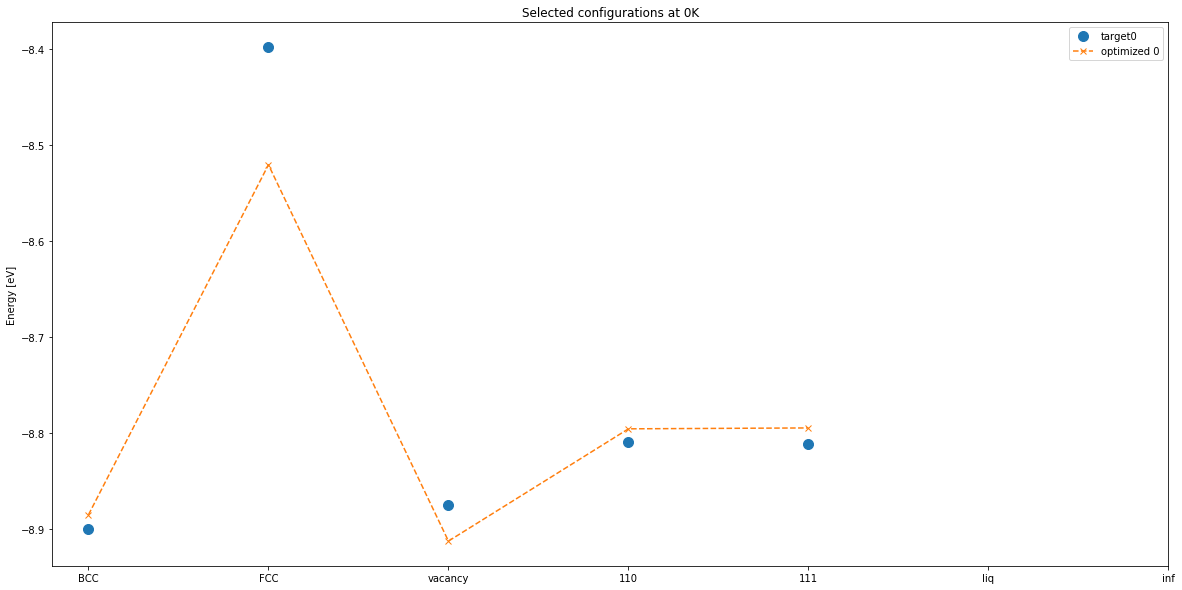

In [92]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-4][:-2])
        print('Model:', opti_out[-4][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-4][:-2]))/nat)
        plt.plot(np.array(targ_out[-4][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    print('Model:', opti_out[-4][:-2])

    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-4][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

In [19]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos_fcc']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][:])
        print('Model:', opti_out[-1][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][:-1]))/nat)
        plt.plot(np.array(targ_out[-1][:-1])/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot( np.array([o for o in opti_out[-1][:-1]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

9


NameError: name 'optimal_parameters' is not defined

<Figure size 1440x720 with 0 Axes>

In [76]:
len(targ_ready['md']['xyz'])

1284

1284
[10.03125 10.03125 10.03125 ... 10.03125 10.03125 10.03125]
0 0.007372937029177636


ValueError: fname must be a PathLike or file handle

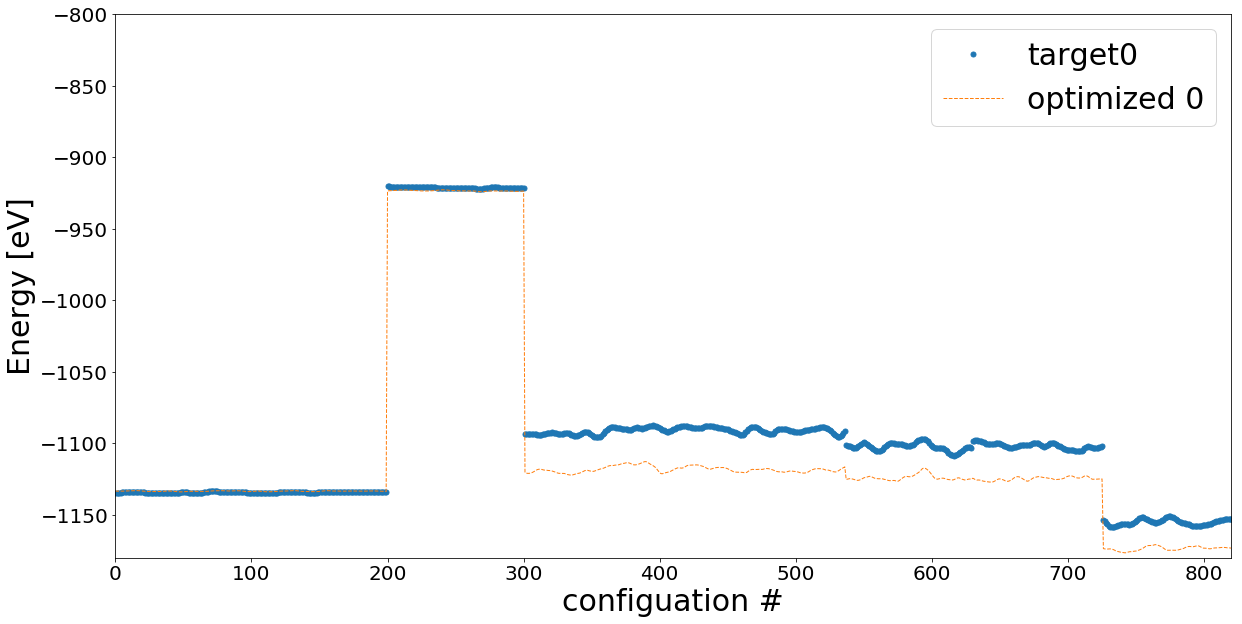

In [95]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[9])
    #plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=5)

        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 1:# and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]', fontsize=30)
plt.xlabel('configuation #', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

#plt.ylim(-1075,-1035)
#plt.ylim(-1000,-900)
#plt.ylim(-950,-900)
#plt.ylim(-1136,-1133)
plt.ylim(-1180,-800)
plt.xlim(0,820)
#plt.xlim(847,990)

#plt.ylim(-1180,-800)

plt.legend(fontsize=30)
plt.savefig(plt.savefig(os.path.join(working, 'bcc_300.png')))

In [120]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

0 4.407570269501649e-05 
 [-1.21658318, 3.2486358e-05, -47.3661687, 22.9965951, -3.42248343, 3.7395698, -1.39292737, -0.833458565, 0.929769431, -0.183568989]
1 6.17447812420396e-05 
 [-1.30551487, 1.41920657e-05, -46.1160967, 22.9352328, -3.42360958, 3.82313395, -1.54715703, -0.697925842, 0.868730239, -0.154592379]
2 9.723561709685708e-05 
 [-1.34624502, 7.49457487e-06, -45.8871674, 22.4064873, -3.46516902, 4.0226376, -1.8966168, -0.431617423, 0.806406324, -0.137562101]
3 0.00014123622250142564 
 [-1.34136558, 1.01769934e-05, -49.3998032, 22.1279115, -3.50791272, 4.16822104, -2.13414308, -0.266237999, 0.783819577, -0.136703203]


In [122]:
stats_opts[it]['hyperparams']

[2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5]

In [123]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 6
pars_out['params'] = [optimal_parameters[1]]

In [124]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [125]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [126]:
optimal_list

[{'pair_nodes': [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
  'mb_node': 6,
  'params': [(6.17447812420396e-05,
    [-1.30551487,
     1.41920657e-05,
     -46.1160967,
     22.9352328,
     -3.42360958,
     3.82313395,
     -1.54715703,
     -0.697925842,
     0.868730239,
     -0.154592379])]}]

In [127]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [128]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [129]:
optimal_list[-1]['params'][0][1]

[-1.30551487,
 1.41920657e-05,
 -46.1160967,
 22.9352328,
 -3.42360958,
 3.82313395,
 -1.54715703,
 -0.697925842,
 0.868730239,
 -0.154592379]

In [130]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [131]:
pair_y, many_y, V_x_r, rho_x_r

([-46.1160967,
  22.9352328,
  -3.42360958,
  3.82313395,
  -1.54715703,
  -0.697925842,
  0.868730239,
  -0.154592379],
 [-1.30551487, 0.0, 1.41920657e-05],
 [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
 [5.0])

In [132]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

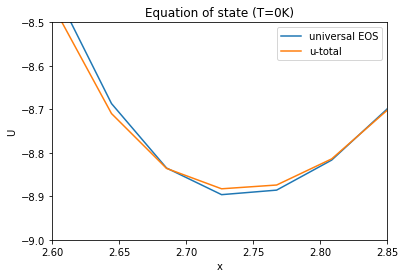

In [149]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.xlim(2.6, 2.85)
plt.ylim(-10,10)
plt.ylim(-9.,-8.5)

plt.xlabel('x')
plt.ylabel(r'U')

In [134]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [135]:
V_x_r

[2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5]

In [136]:
pair_a = optimal_list[-1]['params'][0][1][2:]#pars_in1[2:]
pair_r = optimal_list[-1]['pair_nodes']

rho_a = [1.0]
rho_r = [pair_r[optimal_list[-1]['mb_node']]]

par = optimal_list[-1]['params'][0][1][:2]
many_a = [par[0], 0.0, par[1]]

In [137]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 514.5


In [138]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [139]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [140]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lv_3.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))